In [12]:
from pathlib import Path
import json
import numpy as np
import torch
import imageio
import gym_pusht  # noqa: F401
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv, AsyncVectorEnv
import matplotlib.pyplot as plt

# Import the eval_policy function from the lerobot scripts
from lerobot.scripts.eval import eval_policy
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.common.envs.factory import make_env, make_env_config
from lerobot.common.envs.configs import PushtEnv


In [2]:
output_directory = Path("../../outputs/eval/pushtv1_pretrained-diffusion")
output_directory.mkdir(parents=True, exist_ok=True)

videos_dir = output_directory / "videos"
videos_dir.mkdir(parents=True, exist_ok=True)

In [3]:
device = "cuda"
pretrained_policy_path = "lerobot/diffusion_pusht"

policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
policy.to(device)

# print(policy)
print("\n=== Policy Configuration ===")
print(f"Input features: {policy.config.input_features}")
print(f"Output features: {policy.config.output_features}")
print(f"Image features: {policy.config.image_features}")
print(f"Observation steps: {policy.config.n_obs_steps}")
print(f"Action steps: {policy.config.n_action_steps}")
print(f"Horizon: {policy.config.horizon}")


=== Policy Configuration ===
Input features: {'observation.image': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 96, 96)), 'observation.state': PolicyFeature(type=<FeatureType.STATE: 'STATE'>, shape=(2,))}
Output features: {'action': PolicyFeature(type=<FeatureType.ACTION: 'ACTION'>, shape=(2,))}
Image features: {'observation.image': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 96, 96))}
Observation steps: 2
Action steps: 8
Horizon: 16


In [4]:
env = gym.make(
    "gym_pusht/PushT-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
)
print("Environment observation space:", env.observation_space)
print("Environment action space:", env.action_space)

Environment observation space: Dict('agent_pos': Box(0.0, 512.0, (2,), float64), 'pixels': Box(0, 255, (96, 96, 3), uint8))
Environment action space: Box(0.0, 512.0, (2,), float32)


/home/arito/miniconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment gym_pusht/PushT-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


### Pusht-v1 env

**Env** outputs: env.observation_space
- "pixels" => shape (H, W, 3) where H == W = 96
- "agent_pos" => shape (2,)

**Env** inputs: env.action_space
- shape (2,)

### Diffusion Policy

**Policy** inputs: policy.config.input_features
- "observation.image" => shape (3, H, W) where H == W = 96
- "observation.state" => shape (2,)

**Policy** outputs: policy.config.output_features
- "action" => shape (2,)



In [9]:
# SINGLE ENVIRONMENT ROLLOUT #################################################################

policy.reset()
numpy_observation, info = env.reset(seed=42)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())

step = 0
done = False

while not done:
    state = torch.from_numpy(numpy_observation["agent_pos"])
    image = torch.from_numpy(numpy_observation["pixels"])

    state = state.to(torch.float32).to(device, non_blocking=True)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1).to(device, non_blocking=True)

    # Batch dimension
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    policy_input = {
        "observation.state": state,
        "observation.image": image
    }

    with torch.inference_mode():
        action = policy.select_action(policy_input)

    numpy_action = action.squeeze(0).to("cpu").numpy()

    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    # print(f"{step=} {reward=} {terminated=}")

    rewards.append(reward)
    frames.append(env.render())

    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

# Encode all frames into a mp4 video.
video_path = output_directory / "single_eval_rollout.mp4"
imageio.mimsave(str(video_path), np.stack(frames), fps=fps)

print(f"Video of the evaluation is available in '{video_path}'.")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (680, 680) to (688, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Success!
Video of the evaluation is available in '../../outputs/eval/pushtv1_pretrained-diffusion/single_eval_rollout.mp4'.


In [10]:
# BATCHED ROLLOUT for policy evaluation #####################################################################

# Configure the number of environments and episodes
n_envs = 3  # Number of parallel environments
n_episodes = 3  # Total number of episodes to evaluate
start_seed = 50  # Starting seed

# Create a vectorized environment
env_config = make_env_config(
    env_type="pusht",
    obs_type="pixels_agent_pos",
    render_mode="rgb_array",

)
# print(env_config)

# Create the vectorized environment
env = make_env(
    env_config, 
    n_envs=n_envs,
    use_async_envs=True  # Using AsyncVectorEnv for better performance
)

print(f"Created vectorized environment with {n_envs} parallel environments")
print(f"Running evaluation for {n_episodes} episodes starting from seed {start_seed}")


/home/arito/miniconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment gym_pusht/PushT-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Created vectorized environment with 3 parallel environments
Running evaluation for 3 episodes starting from seed 50


In [11]:
eval_results = eval_policy(
    env=env,
    policy=policy,
    n_episodes=n_episodes,
    max_episodes_rendered=10,  # Only render 1 video
    videos_dir=videos_dir,
    return_episode_data=False,
    start_seed=start_seed,
)

# Close the environment
env.close()

Stepping through eval batches: 100%|██████████| 1/1 [00:59<00:00, 59.31s/it, running_success_rate=100.0%]



=== Evaluation Results ===
Average sum reward: 107.0274
Average max reward: 1.0000
Success rate: 100.00%
Total evaluation time: 60.28 seconds
Average time per episode: 20.09 seconds


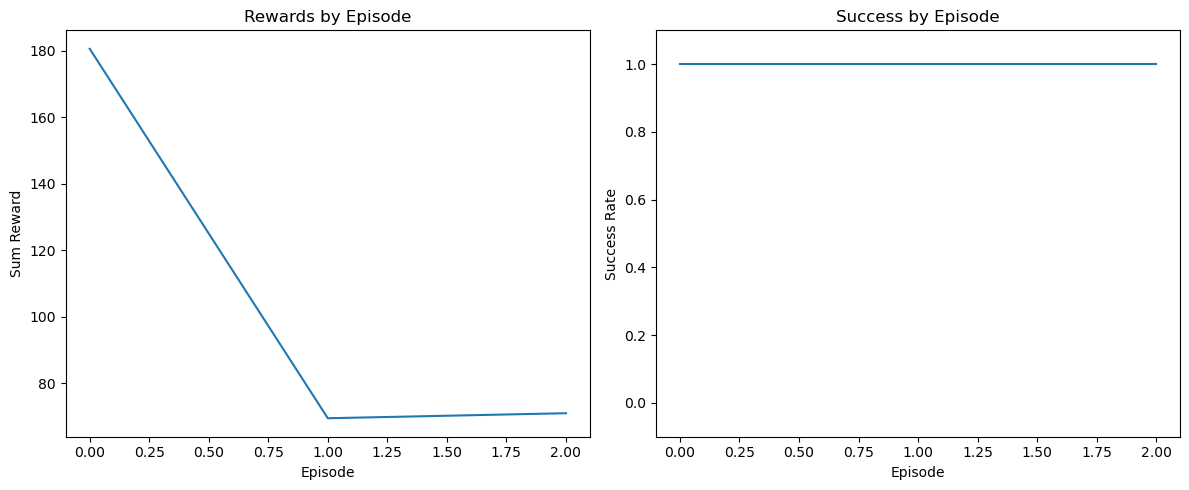


Generated video is available at: ../../outputs/eval/pushtv1_pretrained-diffusion/videos/eval_episode_0.mp4


In [13]:
# Print the aggregated metrics
print("\n=== Evaluation Results ===")
print(f"Average sum reward: {eval_results['aggregated']['avg_sum_reward']:.4f}")
print(f"Average max reward: {eval_results['aggregated']['avg_max_reward']:.4f}")
print(f"Success rate: {eval_results['aggregated']['pc_success']:.2f}%")
print(f"Total evaluation time: {eval_results['aggregated']['eval_s']:.2f} seconds")
print(f"Average time per episode: {eval_results['aggregated']['eval_ep_s']:.2f} seconds")

# If you want to analyze per-episode results
success_by_episode = [ep["success"] for ep in eval_results["per_episode"]]
rewards_by_episode = [ep["sum_reward"] for ep in eval_results["per_episode"]]

plt.figure(figsize=(12, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(rewards_by_episode)
plt.title('Rewards by Episode')
plt.xlabel('Episode')
plt.ylabel('Sum Reward')

# Plot success
plt.subplot(1, 2, 2)
plt.plot([int(s) for s in success_by_episode])
plt.title('Success by Episode')
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(output_directory / "evaluation_results.png")
plt.show()

# Save the evaluation results to a file
with open(output_directory / "eval_results.json", "w") as f:
    json.dump(eval_results, f, indent=2)

# Print video path if any videos were generated
if "video_paths" in eval_results and eval_results["video_paths"]:
    print(f"\nGenerated video is available at: {eval_results['video_paths'][0]}")
else:
    print("No videos generated")


In [14]:
del policy
torch.cuda.empty_cache()